In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
el_prices = pd.read_excel(r'C:\TIO4317_spring25_project\TIO4317_spring25_project\data\Processed\ice_electric-ave_price-2015-2025.xlsx')
el_prices.set_index('Trade date', inplace=True)

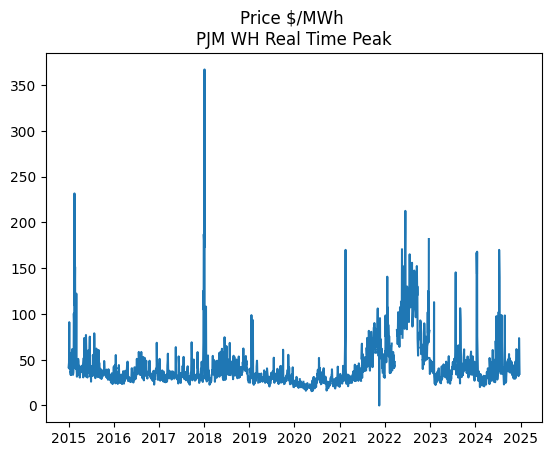

In [131]:
#Velger en, Price Mid C, siden den hadde punkter over hele perioden. 
#1 Exploratory analysis 

plt.figure()
plt.plot(el_prices["Price $/MWh \nPJM WH Real Time Peak"])
plt.title("Price $/MWh \nPJM WH Real Time Peak")
plt.show()

#Mye spikes; antagelig vinter demand. Mer volatilt etter 2021 

In [ ]:
gi#2 Stationarity
from statsmodels.tsa.stattools import adfuller


In [6]:
#Noen datoer har flere punkter som blir et problem når man skal lage en serie med frequency
#Tok bort duplicates i preprocessing-koden.
duplicates = el_prices.index[el_prices.index.duplicated()]
print(duplicates)

DatetimeIndex([], dtype='datetime64[ns]', name='Trade date', freq=None)


In [ ]:
#Define series with set frequency 

el_price_mid_C = el_prices["Price $/MWh \nMid C Peak"].asfreq('B')
el_price_PJM = el_prices["Price $/MWh \nPJM WH Real Time Peak"].asfreq('B')
#Har testet med begge, men går videre med å se på PJM (01.04.25)
el_price = el_price_PJM 

In [ ]:
#el_price_PJM.isna().sum()
#na_indices = el_price_PJM[el_price_PJM.isna()].index
#print(na_indices)
#el_prices.columns

#Dette feltet var for å undersøke missing values. 

In [8]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if result[1] < 0.05:
        print("Conclusion: The series is likely stationary.")
    else:
        print("Conclusion: The series is likely non-stationary.")

In [33]:
#adf_test(el_price_mid_C)
adf_test(el_price)

ADF Statistic: -4.7224
p-value: 0.0001
Critical Values:
   1%: -3.4330
   5%: -2.8627
   10%: -2.5674
Conclusion: The series is likely stationary.


In [39]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity
    print(f'KPSS Statistic: {result[0]}')
    print(f'P-value: {result[1]}')
    print(f'Critical Values: {result[3]}')
    if result[1] < 0.05:
        print("Reject null hypothesis: The series is likely non-stationary.")
    else:
        print("Fail to reject null hypothesis: The series is likely stationary.")

In [ ]:
kpss_test(el_price)

KPSS Statistic: 1.079718961849915
P-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject null hypothesis: The series is likely non-stationary.


C:\Users\endre\AppData\Local\Temp\ipykernel_24820\2214210753.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity


In [10]:
#Overraskende sier den at den er stationary!

#Lager en ARIMA modell

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

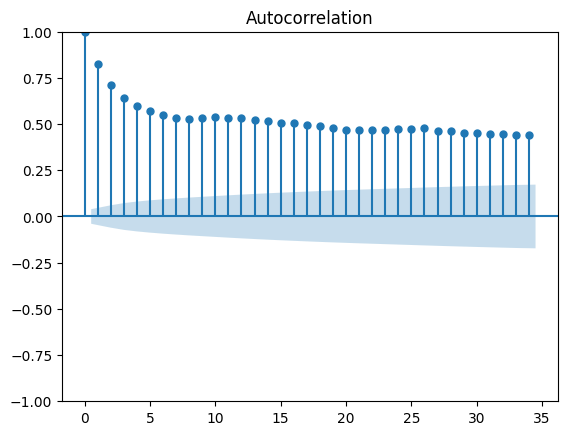

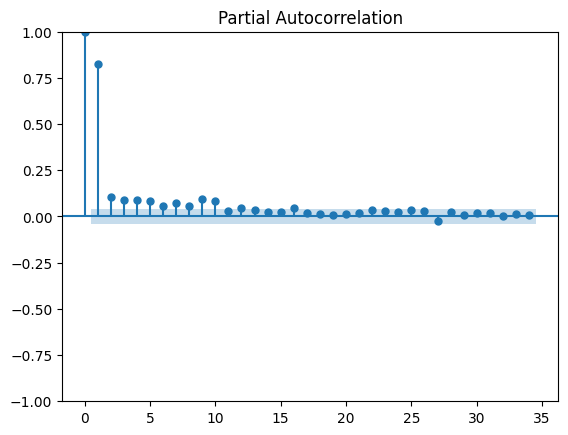

In [34]:
plot_acf(el_price.dropna())
plot_pacf(el_price.dropna())
plt.show()

#ACF og PACF plots can guide parameter selection. 

p → Autoregressive (AR) term (from PACF plot)

d → Number of differences needed to achieve stationarity

q → Moving average (MA) term (from ACF plot) 

Choose for now: p=3, d=0, q=3
Can also use information criteria: AIC or BIC



In [101]:
p = 3
d = 0 
q = 3

model = ARIMA(el_price, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

#Det er noe error her...i forhold til non-stationarity. 

                                       SARIMAX Results                                        
Dep. Variable:     Price $/MWh 
PJM WH Real Time Peak   No. Observations:                 2603
Model:                                 ARIMA(3, 0, 3)   Log Likelihood               -9915.963
Date:                                Tue, 01 Apr 2025   AIC                          19847.927
Time:                                        12:20:21   BIC                          19894.842
Sample:                                    01-02-2015   HQIC                         19864.924
                                         - 12-24-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.5946      9.007      4.729      0.000      24.941      60.248
ar.

Ser på om det er mulig å ta log-verdier. 

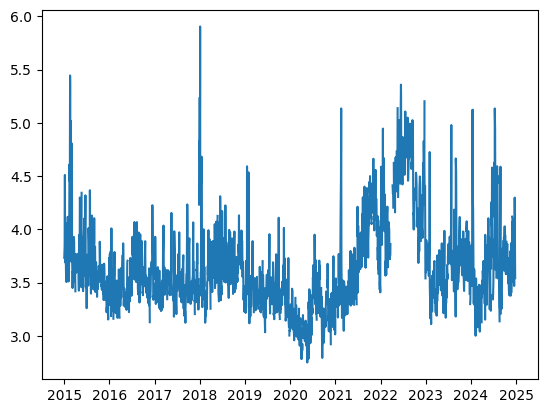

In [ ]:
df = pd.DataFrame(el_price)
df["Log_Values"] = np.log(df["Price $/MWh \nPJM WH Real Time Peak"].replace(0, np.nan))
el_price_log = df["Log_Values"].asfreq('B')
el_price_log

plt.plot(el_price_log)
#plt.plot(el_price)


In [ ]:
df['Diff_Value_Log'] = df['Log_Values'].diff()

,Price $/MWh \nPJM WH Real Time Peak,Log_Values,Diff_Value_Log
Trade date,,,
2015-01-02,41.76,3.731939,NaN
2015-01-05,46.81,3.846097,0.114158
2015-01-06,82.97,4.418479,0.572382
2015-01-07,90.95,4.510310,0.091831
2015-01-08,52.80,3.966511,-0.543799
...,...,...,...
2024-12-18,35.51,3.569814,0.026539
2024-12-19,37.81,3.632574,0.062759
2024-12-20,73.51,4.297421,0.664848


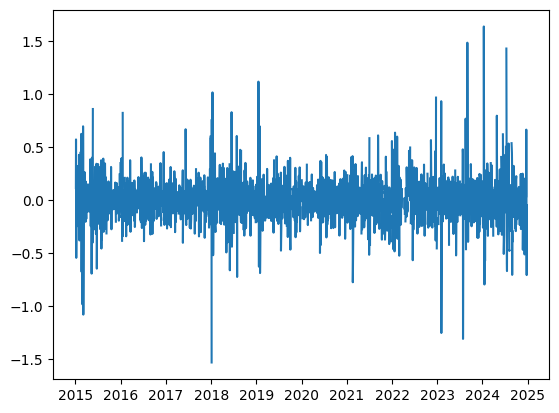

In [100]:
log_diff_PJM = df["Diff_Value_Log"].asfreq('B')
plt.plot(log_diff_PJM)

In [99]:
adf_test(log_diff_PJM)
kpss_test(log_diff_PJM)

ADF Statistic: -20.6489
p-value: 0.0000
Critical Values:
   1%: -3.4332
   5%: -2.8628
   10%: -2.5674
Conclusion: The series is likely stationary.
KPSS Statistic: 0.04588074794090207
P-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject null hypothesis: The series is likely stationary.


C:\Users\endre\AppData\Local\Temp\ipykernel_24820\2214210753.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')  # 'c' for constant, 'ct' for trend stationarity


In [128]:
p = 3
d = 1 
q = 3

model = ARIMA(el_price_log, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Log_Values   No. Observations:                 2603
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 575.020
Date:                Tue, 01 Apr 2025   AIC                          -1136.040
Time:                        12:50:48   BIC                          -1094.992
Sample:                    01-02-2015   HQIC                         -1121.168
                         - 12-24-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0703      6.468     -0.011      0.991     -12.747      12.606
ar.L2          0.3291      2.806      0.117      0.907      -5.170       5.828
ar.L3          0.0397      0.643      0.062      0.9

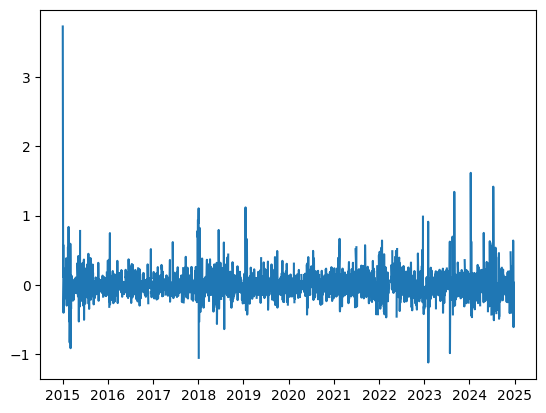

In [118]:
#model_fit.plot_diagnostics(figsize=(10, 6))
residuals = model_fit.resid
plt.plot(residuals)
plt.show()

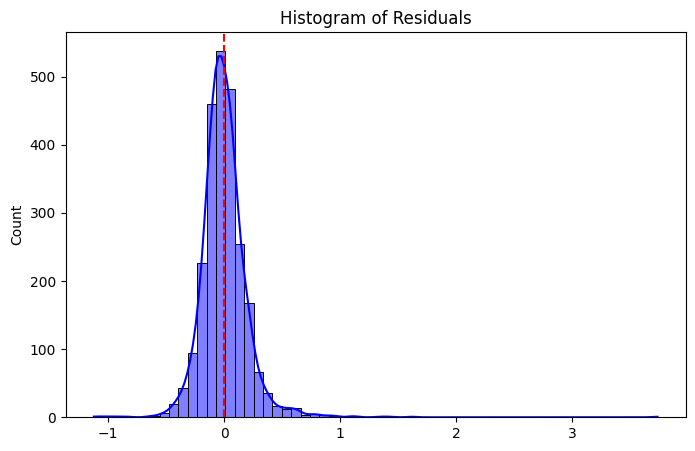

In [120]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=60, color='blue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Histogram of Residuals")
plt.show()

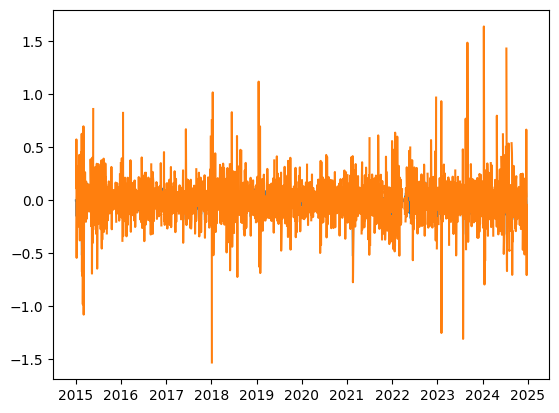

In [125]:
fitted_values = model_fit.fittedvalues
plt.plot(fitted_values)
plt.plot(log_diff_PJM)


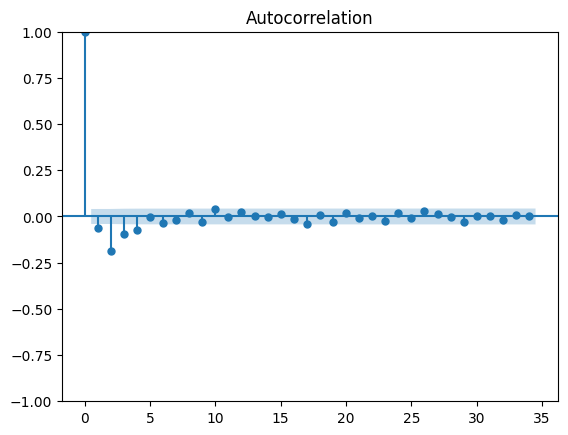

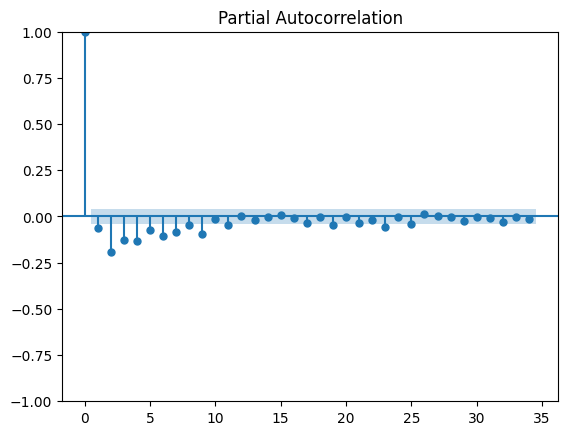

In [127]:
plot_acf(log_diff_PJM.dropna())
plot_pacf(log_diff_PJM.dropna())
plt.show()